In [9]:
# import os
# import shutil

# # Define the path to the input and output directories
# input_dir = '/Users/izzymohamed/Desktop/Vision For Social Good/DATA/Cherry/03_11_2021/Ground_Multispectral_Photos_all'
# output_dir = '/Users/izzymohamed/Desktop/Vision For Social Good/DATA/Cherry/03_11_2021/Ground_Multispectral_Photos_all'

# # Ensure the output directory exists
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # Walk through the directory tree
# for root, dirs, files in os.walk(input_dir):
#     for file_name in files:
#         if file_name.endswith('.JPG'):
#             # Get the full path of the file
#             file_path = os.path.join(root, file_name)
            
#             # Extract the parent folder name from the path
#             parent_folder_name = os.path.basename(root)
            
#             # Create the new file name and path
#             new_file_name = f"{parent_folder_name}{os.path.splitext(file_name)[1]}"
#             new_file_path = os.path.join(output_dir, new_file_name)
#             print(new_file_path)
            
#             # Move and rename the file to the output directory
#             shutil.move(file_path, new_file_path)

# print("JPG files have been renamed and moved to the output directory.")

In [10]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

In [11]:
# Constants
RGB_IMAGE_DIR = "/Users/izzymohamed/Desktop/Vision For Social Good/DATA/Cherry/03_11_2021/Ground_RGB_Photos_all"
MULTISPECTRAL_IMAGE_DIR = "/Users/izzymohamed/Desktop/Vision For Social Good/DATA/Cherry/03_11_2021/Ground_Multispectral_Photos_all"
UAV_IMAGE_DIR = "/Users/izzymohamed/Desktop/Vision For Social Good/DATA/Cherry/03_11_2021/Aerial_UAV_photos"
ANNOTATIONS_FILE = "/Users/izzymohamed/Desktop/Vision For Social Good/DATA/Cherry/03_11_2021/03_11_2021.csv"
IMAGE_SIZE = (256, 256)
NUM_CLASSES = 4

In [12]:
# Paths to the uploaded images
red_image_path = UAV_IMAGE_DIR + '/red.rgb.tif'
nir_image_path = UAV_IMAGE_DIR + '/nir.rgb.tif'

In [13]:
# Function to calculate the NDVI
def calculate_ndvi(red_image_path, nir_image_path):
    red = Image.open(red_image_path).convert('L')
    nir = Image.open(nir_image_path).convert('L')

    red = np.asarray(red).astype(np.float32)
    nir = np.asarray(nir).astype(np.float32)

    # Avoid division by zero
    np.seterr(divide='ignore', invalid='ignore')

    ndvi = (nir - red) / (nir + red)
    
    # Plotting the NDVI
    plt.imshow(ndvi, cmap='RdYlGn')
    plt.colorbar()
    plt.title('NDVI')
    plt.show()

    return ndvi

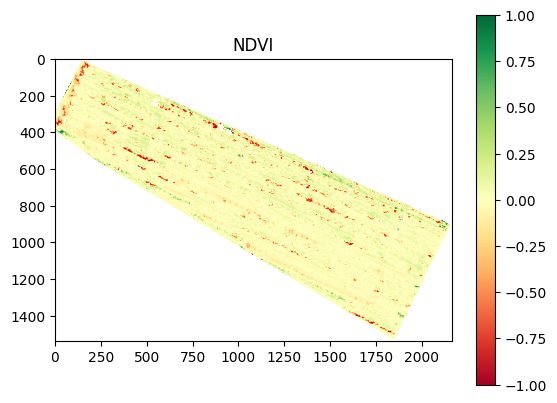

In [14]:
# Calculate and visualize NDVI
ndvi = calculate_ndvi(red_image_path, nir_image_path)

In [15]:
# Load annotations
annotations = pd.read_csv(ANNOTATIONS_FILE, header=None, names=['images', 'labels'])
print(annotations.columns)

Index(['images', 'labels'], dtype='object')


In [16]:
# Encode labels
label_encoder = LabelEncoder()
annotations['label_encoded'] = label_encoder.fit_transform(annotations['labels'])

In [17]:
# Function to load images
def load_images(image_dir, img_size=(224, 224)):
    images = []
    for filename in os.listdir(image_dir):
        img_path = os.path.join(image_dir, filename)
        img = cv.imread(img_path)
        if img is not None:
            img_resized = cv.resize(img, img_size)
            images.append(img_resized)
    return np.array(images)

In [18]:
# Load RGB and multispectral images
rgb_images = load_images(RGB_IMAGE_DIR)
multispectral_images = load_images(MULTISPECTRAL_IMAGE_DIR)
uav_images = load_images(UAV_IMAGE_DIR)

[ WARN:0@167.344] global grfmt_tiff.cpp:710 readData OpenCV TIFF: TIFFRGBAImageOK: Sorry, can not handle images with 32-bit samples
[ WARN:0@167.345] global grfmt_tiff.cpp:710 readData OpenCV TIFF: TIFFRGBAImageOK: Sorry, can not handle images with 32-bit samples
[ WARN:0@167.363] global grfmt_tiff.cpp:710 readData OpenCV TIFF: TIFFRGBAImageOK: Sorry, can not handle images with 32-bit samples
[ WARN:0@167.380] global grfmt_tiff.cpp:710 readData OpenCV TIFF: TIFFRGBAImageOK: Sorry, can not handle images with 32-bit samples
[ WARN:0@167.380] global grfmt_tiff.cpp:710 readData OpenCV TIFF: TIFFRGBAImageOK: Sorry, can not handle images with 32-bit samples


In [19]:
# Ensure the number of images matches the annotations
assert len(rgb_images) == len(annotations), "Mismatch between number of RGB images and annotations"
assert len(multispectral_images) == len(annotations), "Mismatch between number of multispectral images and annotations"
# assert len(uav_images) == len(annotations), "Mismatch between number of UAV images and annotations"

In [20]:
# Prepare labels
labels = annotations['label_encoded'].values

In [24]:
# Split data into training and testing sets
X_train_rgb, X_test_rgb, X_train_multispectral, X_test_multispectral, X_train_uav, X_test_uav, y_train, y_test = train_test_split(
    rgb_images, multispectral_images, uav_images, labels, test_size=0.2, random_state=42
)

ValueError: Found input variables with inconsistent numbers of samples: [577, 577, 5, 577]

In [ ]:
# Early Fusion of RGB, multispectral, and UAV images
def early_fusion(rgb_images, multispectral_images, uav_images):
    return np.concatenate((rgb_images, multispectral_images, uav_images), axis=-1)

In [ ]:
X_train_fused = early_fusion(X_train_rgb, X_train_multispectral, X_train_uav)
X_test_fused = early_fusion(X_test_rgb, X_test_multispectral, X_test_uav)

NameError: name 'X_train_uav' is not defined

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_fused, dtype=torch.float32).permute(0, 3, 1, 2)
X_test_tensor = torch.tensor(X_test_fused, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
# Dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [ ]:
# DataLoader
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class CustomPatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=6, embed_dim=768):
        super(CustomPatchEmbed, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/P, W/P)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

In [ ]:
class ViTModel(nn.Module):
    def __init__(self, img_size=224, num_classes=4, in_chans=6):
        super(ViTModel, self).__init__()
        self.embed_dim = 768
        self.patch_embed = CustomPatchEmbed(img_size=img_size, patch_size=16, in_chans=in_chans, embed_dim=self.embed_dim)
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit.patch_embed = self.patch_embed  # Replace patch embedding
        self.vit.head = nn.Identity()  # Remove the original classification head

        self.fc1 = nn.Linear(self.embed_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.vit.forward_features(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Create the model
num_classes = 4
model = ViTModel(num_classes)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 50
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_vit_model.pth')

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.4f}")

print(f"Best Accuracy: {best_accuracy:.4f}")